In [103]:
import pandas as pd
import numpy as np
from numpy import sqrt
import os
import requests
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

# Analyzing US Census Data in Python

## Decennial Census of Population and Housing

Start exploring Census data products with the Decennial Census. Use the Census API and the requests package to retrieve data, load into pandas data frames, and conduct exploratory visualization in seaborn. Learn about important Census geographies, including states, counties, and tracts.


### Census Subject Tables

In [2]:
# Get the current working directory
cwd = os.getcwd()

# Define the file path
file_path = os.path.join(cwd, 'states.csv')

# Read the CSV file
states = pd.read_csv(file_path, index_col=0)


In [3]:
# Set list of Hispanic race column names
hispanic_races = [
    "hispanic_white", 
    "hispanic_black", "hispanic_aian", 
    "hispanic_asian", "hispanic_pacific", 
    "hispanic_other", "hispanic_multiracial"
    ]

# What percentage of Hispanics identify as each race?
print(round(100 * states[hispanic_races].sum() / states['hispanic'].sum(), 2))

hispanic_white          54.52
hispanic_black           3.14
hispanic_aian            1.30
hispanic_asian           0.39
hispanic_pacific         0.11
hispanic_other          34.69
hispanic_multiracial     5.84
dtype: float64


In [4]:
# Create a deep copy of only the Hispanic race columns
states_hr = states[hispanic_races].copy()

# Calculate percentages for all columns in the date frame
for race in hispanic_races:
    states_hr[race] = 100 * states[race] / states["hispanic"]

# View the result
display(states_hr.head())

,hispanic_white,hispanic_black,hispanic_aian,hispanic_asian,hispanic_pacific,hispanic_other,hispanic_multiracial
Alabama,38.249588,3.703624,1.245137,0.354522,0.582429,50.042564,5.822136
Alaska,46.513287,3.347856,5.898239,1.722337,0.484089,25.455426,16.578766
Arizona,51.261088,1.050419,2.063321,0.326412,0.089122,39.739408,5.470230
Arkansas,38.570277,1.501209,1.109917,0.244558,0.190271,52.378393,6.005375
California,46.366571,0.965254,1.431105,0.613235,0.112811,44.469173,6.041851


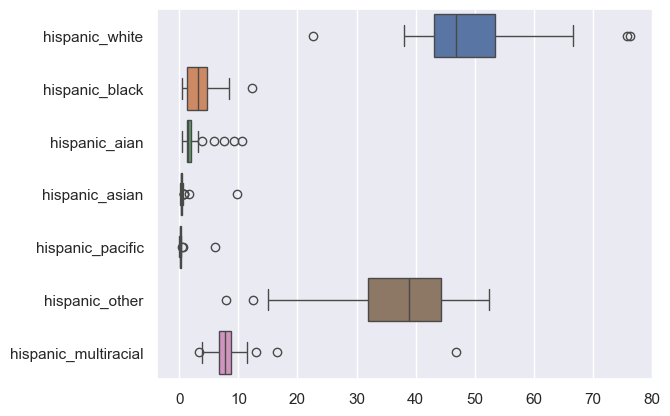

In [5]:
sns.set()

# Create a boxplot
sns.boxplot(data = states_hr, orient = "h")
plt.show()

In [6]:
# Show states with extreme values in various columns
display(states_hr.nlargest(1, 'hispanic_white').squeeze())
display(states_hr.nsmallest(1,'hispanic_other').squeeze())
display(states_hr.nlargest(1, 'hispanic_asian').squeeze())

hispanic_white          76.339680
hispanic_black           3.521989
hispanic_aian            0.572777
hispanic_asian           0.227402
hispanic_pacific         0.060633
hispanic_other          14.978955
hispanic_multiracial     4.298564
Name: Florida, dtype: float64

hispanic_white          75.862495
hispanic_black          12.385538
hispanic_aian            0.528948
hispanic_asian           0.105762
hispanic_pacific         0.007944
hispanic_other           7.831978
hispanic_multiracial     3.277334
Name: Puerto Rico, dtype: float64

hispanic_white          22.555072
hispanic_black           1.257841
hispanic_aian            1.109714
hispanic_asian           9.751576
hispanic_pacific         5.958193
hispanic_other          12.493173
hispanic_multiracial    46.874431
Name: Hawaii, dtype: float64

### Using The Census API

#### Basic API Request
Construct an API request to retrieve the average family size and median age for all states in the United States. The data will come from Summary File 1 of the 2010 Decennial Census.

In [7]:
# Build base URL
HOST = "https://api.census.gov/data"  # API host URL
year = "2010"  # Specify the year of the data
dataset = "dec/sf1"  # Specify the dataset (decennial census summary file 1)
base_url = "/".join([HOST, year, dataset])  # Construct the full base URL

# Specify Census variables and other predicates
get_vars = ['NAME','P013001','P037001']  # List of variables to request from the dataset
predicates = {}  
predicates["get"] = ",".join(get_vars)  # Join variables into a single string for the "get" parameter
predicates["for"] = "state:*"  # Specify the geography (all states in this case)

# Execute the request, examine text of response object
r = requests.get(base_url, params=predicates)  # Send GET request to the API with parameters

In [8]:
# Construct the DataFrame
col_names = ['name', 
            'median_age', 
            'avg_family_size', 
            'state']
states = pd.DataFrame(columns = col_names, data = r.json()[1:])

# Convert each column with numeric data to an appropriate type
states["median_age"] = states["median_age"].astype('float')
states["avg_family_size"] = states['avg_family_size'].astype('float')

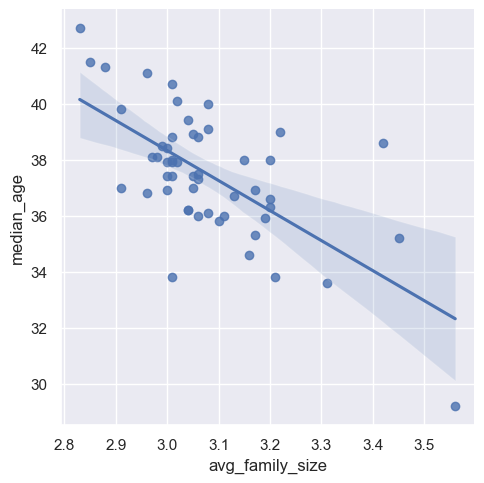

In [9]:
# Scatterplot with regression line
sns.lmplot(x = "avg_family_size", y = "median_age", data = states)
plt.show()

#### API to Visualization: Group Quarters

Investigate where juvenile offenders are incarcerated. This analysis introduces the concept of "group quarters" populations, which includes college dorms, correctional facilities, nursing homes, military bases, etc.

Visualize the percentage, by state, of incarcerated minor males in adult correctional facilities. The variables to request are:

`PCT021005` - Male: Under 18 years: Institutionalized population: Correctional facilities for adults
`PCT021015` - Male: Under 18 years: Institutionalized population: Juvenile facilities: Correctional facilities intended for juveniles
requests has been imported. The base_url for the API request has been defined.


In [10]:
# Specify Census variables and other predicates
get_vars = ['NAME','PCT021005','PCT021015']  # List of variables to request from the dataset
predicates = {}  
predicates["get"] = ",".join(get_vars)  # Join variables into a single string for the "get" parameter
predicates["for"] = "state:*"  # Specify the geography (all states in this case)

In [11]:
# Specify variables and execute API request
predicates["get"] = ",".join(get_vars)
r = requests.get(base_url, params=predicates)

In [12]:
print(r.text)

[["NAME","PCT021005","PCT021015","state"],
["Alabama","131","536","01"],
["Alaska","83","92","02"],
["Arizona","681","629","04"],
["Arkansas","89","541","05"],
["California","321","6489","06"],
["Louisiana","362","655","22"],
["Kentucky","4","660","21"],
["Colorado","103","767","08"],
["Connecticut","1","293","09"],
["Delaware","18","171","10"],
["District of Columbia","28","27","11"],
["Florida","1119","3092","12"],
["Georgia","803","1442","13"],
["Hawaii","0","58","15"],
["Idaho","21","324","16"],
["Illinois","584","1039","17"],
["Indiana","194","1053","18"],
["Iowa","35","394","19"],
["Kansas","49","540","20"],
["Maine","0","93","23"],
["Maryland","277","442","24"],
["Massachusetts","242","277","25"],
["Michigan","408","1140","26"],
["Minnesota","36","648","27"],
["Mississippi","164","1438","28"],
["Missouri","150","524","29"],
["Montana","11","142","30"],
["Nebraska","39","354","31"],
["Nevada","74","275","32"],
["New Hampshire","19","56","33"],
["New Jersey","17","640","34"],
["Ne

In [13]:
# Construct DataFrame
col_names = ["name", "in_adult", "in_juvenile", "state"]
states = pd.DataFrame(columns=col_names, data=r.json()[1:])
states[["in_adult", "in_juvenile"]] = states[["in_adult", "in_juvenile"]].astype('int','int')

In [14]:
# Calculate percentage of incarcerated male minors in adult facilities
states["pct_in_adult"] = 100 * states['in_adult']/(states['in_adult']+states['in_juvenile'])
states.sort_values(by = 'pct_in_adult', ascending = False, inplace = True)

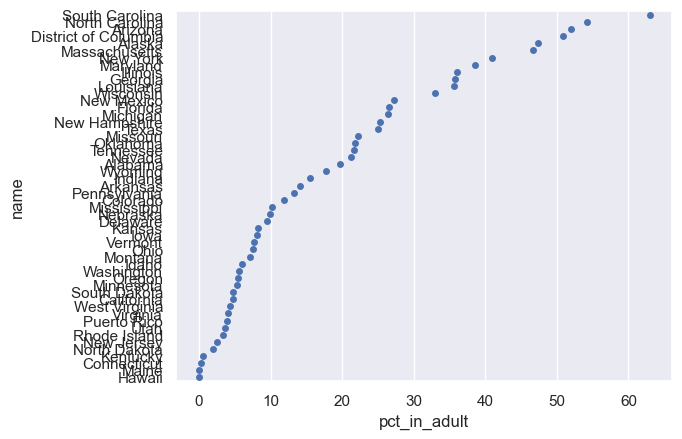

In [15]:
sns.stripplot(x = "pct_in_adult", y = "name", data = states)
plt.show()

### Census Geographies

#### Specific Places

Looking up geographic identifiers for major cities. The Census classifies cities and other municipalities as "places". Find place codes using the [Geographic Codes Lookup at the Missouri Census Data Center](https://mcdc.missouri.edu/applications/geocodes/).

The variables to request are place names and total population.

In [16]:
# Build dictionary of predicates
get_vars = ["NAME", "P001001"]  # Define a list of variables to request (NAME and total population)
predicates = {} 
predicates["get"] = ",".join(get_vars)  # Convert the list into a comma-separated string for the 'get' parameter
predicates["for"] = "place:60000,61000"  # Specify the geographic filter for places with FIPS codes Cities of Philadelphia (60000) and Pittsburgh (61000)
predicates["in"] = "state:42"  # Specify the state filter (42, Pennsylvania)

# Execute the request
r = requests.get(base_url, params=predicates)  # Send a GET request to the API with the defined parameters

#### Congressional Districts by State

A Pennsylvania-based family advocacy nonprofit wants to find the average family size by Congressional district (`P037001`), so that they can call representatives from districts with relatively large families. 

In [17]:
# Build dictionary of predicates and execute the request
get_vars = ["NAME", "P037001"]  # List of variables to retrieve
predicates = {} 
predicates['get'] = ",".join(get_vars)  # Join the get_vars list into a comma-separated string
predicates["for"] = "congressional district:*"  # Specify the 'for' predicate, requesting data for all (*) congressional districts
predicates["in"] = "state:42"  # Specify the 'in' predicate, requesting data for the state with code 42 (which represents Pennsylvania)
r = requests.get(base_url, params=predicates)  # Make a GET request to the API with the specified base_url and parameters

In [18]:
# Construct the DataFrame
col_names = ["name", "avg_family_size", "state", "cd"]  # Define the column names for the DataFrame ('cd' stands for congressional district)
cd = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Create a DataFrame from the JSON response, excluding the first element

In [19]:
# Set data type and print
cd["avg_family_size"] = cd["avg_family_size"].astype(float)  # Convert the 'avg_family_size' column to float type
display(cd.head())  # Print the entire DataFrame after converting the 'avg_family_size' column

,name,avg_family_size,state,cd
0,"Congressional District 1 (111th Congress), Pen...",3.32,42,01
1,"Congressional District 2 (111th Congress), Pen...",3.10,42,02
2,"Congressional District 3 (111th Congress), Pen...",2.95,42,03
3,"Congressional District 4 (111th Congress), Pen...",2.94,42,04
4,"Congressional District 5 (111th Congress), Pen...",2.88,42,05


#### Zip Code Tabulation Areas
In the marketing field, it is very common to want to know ZIP Code demographics. ZIP Code Tabulation Areas ("ZCTAs") are Census-defined equivalents to ZIP Codes that are built out of Census blocks. Request total population for all ZCTAs in the state of Alabama.

In [20]:
# Build dictionary of predicates and execute the request
predicates = {}
predicates["get"] = ",".join(["NAME",  "P001001"])
predicates['in'] = 'state:01'
predicates['for'] = 'zip code tabulation area (or part):*'
r = requests.get(base_url, params=predicates)

# Construct the DataFrame
col_names = ["name", "total_pop", "state", "zcta"]
zctas = pd.DataFrame(columns=col_names, data=r.json()[1:])
zctas["total_pop"] = zctas["total_pop"].astype(int)

# Set multilevel index from GEOIDs and print the head
zctas.set_index(['state', 'zcta'], inplace = True)
print(zctas.head())

                                    name  total_pop
state zcta                                         
01    30165  ZCTA5 30165 (part), Alabama         70
      31905  ZCTA5 31905 (part), Alabama          9
      35004         ZCTA5 35004, Alabama      10427
      35005         ZCTA5 35005, Alabama       7942
      35006         ZCTA5 35006, Alabama       3121


## American Community Survey

Explore topics such as health insurance coverage and gentrification using the American Community Survey. Calculate Margins of Error and explore change over time. Create choropleth maps using geopandas.

### Basic Mapping of Geopandas

### Neiborhood Change

### Annual Change

#### Home Values in California
California's major cities have been in the news for skyrocketing housing prices. How has the median home value changed over the last several years? Use a loop to request variable `B25077_001E` from seven ACS years and plot the value over time.

In [21]:
# Build base URL and predicates
HOST = "https://api.census.gov/data"  # API host URL
dataset = "acs/acs1"  # Specify the dataset (American Community Survey 1-year data)
predicates = {}  
predicates["get"] = ",".join(["NAME",  "B25077_001E"])  # Define the variables to be retrieved: name and median home value
predicates['for'] = 'state:06'  # Define the filter to only include data for California (state code 06)

# Loop over years 2011 to 2019
dfs = []  # Initialize an empty list to collect DataFrames
col_names = ['name', 'median_home_value', 'state']  # Define column names for the DataFrames

for year in range(2011, 2020): 
    base_url = "/".join([HOST, str(year), dataset])  # Construct the full base URL for the API request
    r = requests.get(base_url, params=predicates)  # Make a GET request to the API with the parameters
    df = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Convert the JSON response to a DataFrame, excluding the first row (headers)
    df['year'] = year  # Add a new column to the DataFrame to store the year
    dfs.append(df)  # Append the DataFrame for the current year to the list of DataFrames

In [22]:
# Concatenate all DataFrames, fix column type
states = pd.concat(dfs, ignore_index=True)  # Concatenate all DataFrames from the list 'dfs', resetting the index
states["median_home_value"] = states["median_home_value"].astype(int)  # Convert the 'median_home_value' column to integer type

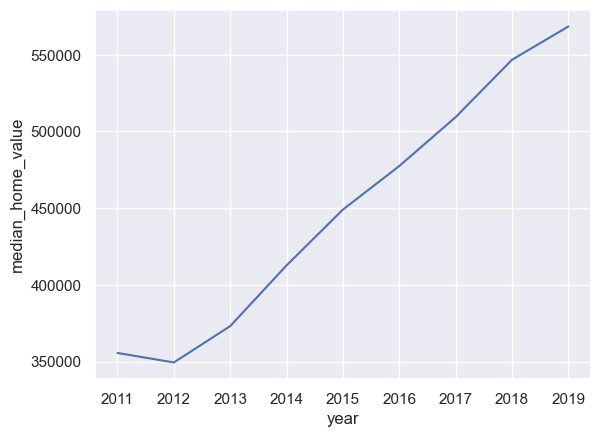

In [23]:
# Plot results of median home value
sns.lineplot(x='year', y='median_home_value', data = states) 
plt.show() 

#### Health Insurance Coverage
The Affordable Care Act went into effect in 2014. One of its goals was to increase health insurance coverage among healthy young adults. Has health insurance coverage among 19-25 year olds changed with the passage of the Affordable Care Act? Let's calculate the percentage point change in coverage by state. Then plot the change against the initial percent covered rate.

ACS Table `B27022` - "Health Insurance Coverage Status By Sex By Enrollment Status For Young Adults Aged 19 To 25" has been loaded. Columns names (printed to the console) indicate breakdowns by sex (m/f), school enrollment (school/noschool) and insurance (insured/uninsured).

In [24]:
# Build base URL and predicates
HOST = "https://api.census.gov/data"  # API host URL for Census data
dataset = "acs/acs1"  # Specify the dataset (American Community Survey 1-year data)
predicates = {}  

# Define the actual variable codes that correspond to the columns
variable_codes = ['NAME']  # 'NAME' is a special column that contains location names
for i in range(1, 16): 
    variable_codes.append(f'B27022_{i:03}E')  # Append the codes for variables with leading zeros

# Define predicates for the API request
predicates["get"] = ",".join(variable_codes)  # Join the list of variable codes into a single comma-separated string
predicates['for'] = 'state:*'  # Define the filter to get data for all states (state:*) 

# Loop over years 2013 to 2017
dfs = []  # Initialize an empty list to collect DataFrames for each year
col_names = ['name', 'total', 'm', 'm_school', 'm_school_insured', 'm_school_uninsured', 
             'm_noschool', 'm_noschool_insured', 'm_noschool_uninsured', 'f', 'f_school', 
             'f_school_insured', 'f_school_uninsured', 'f_noschool', 'f_noschool_insured', 
             'f_noschool_uninsured', 'state']  # Column names for the DataFrame

for year in range(2013, 2024):  # Loop over the years from 2013 to 2017
    if year != 2020:
        base_url = "/".join([HOST, str(year), dataset])  # Construct the full base URL for the API request by joining host, year, and dataset
        print(f"Requesting data for year {year} from URL: {base_url}")  # Print the URL for debugging purposes
        r = requests.get(base_url, params=predicates)  # Make a GET request to the Census API with the parameters
        df = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Convert the JSON response to a DataFrame, excluding the first row (headers)
        df['year'] = year  # Add a new column to store the year in the DataFrame
        dfs.append(df)  # Append the DataFrame for the current year to the list of DataFrames

# Concatenate all DataFrames and reset index
states = pd.concat(dfs, ignore_index=True)  # Concatenate all DataFrames in the list 'dfs', resetting the index

# Convert the relevant columns to integers
my_columns = states.columns.to_list()[1:16]  # Select the columns from index 1 to 15 (excluding the first column 'name')
for i in my_columns:  # Loop over the selected columns
    states[i] = states[i].astype(int)  # Convert the values in each column to integers
print("The 'states' DataFrame is now ready for use.")  # Indicating the DataFrame is prepared and ready

Requesting data for year 2013 from URL: https://api.census.gov/data/2013/acs/acs1
Requesting data for year 2014 from URL: https://api.census.gov/data/2014/acs/acs1
Requesting data for year 2015 from URL: https://api.census.gov/data/2015/acs/acs1
Requesting data for year 2016 from URL: https://api.census.gov/data/2016/acs/acs1
Requesting data for year 2017 from URL: https://api.census.gov/data/2017/acs/acs1
Requesting data for year 2018 from URL: https://api.census.gov/data/2018/acs/acs1
Requesting data for year 2019 from URL: https://api.census.gov/data/2019/acs/acs1
Requesting data for year 2021 from URL: https://api.census.gov/data/2021/acs/acs1
Requesting data for year 2022 from URL: https://api.census.gov/data/2022/acs/acs1
Requesting data for year 2023 from URL: https://api.census.gov/data/2023/acs/acs1
The 'states' DataFrame is now ready for use.


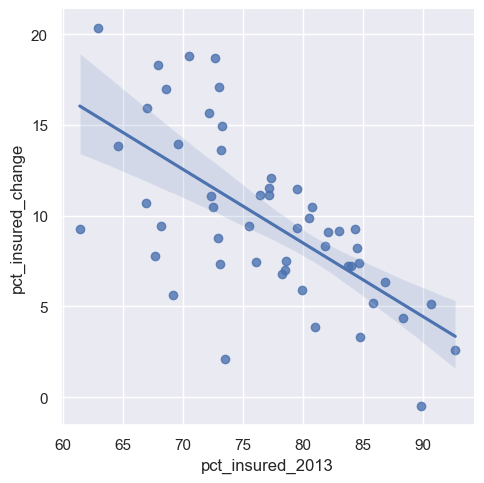

In [25]:
states_2013_2017=states[states['year'].isin([2013,2017])].copy()

# Calculate percent insured
states_2013_2017["insured_total"] = states_2013_2017["m_school_insured"] +  states_2013_2017["m_noschool_insured"] + states_2013_2017["f_school_insured"] + states_2013_2017["f_noschool_insured"]
states_2013_2017["pct_insured"] = 100 * states_2013_2017['insured_total']/states_2013_2017['total']

# Pivot the table and rename the columns
states_pvt = states_2013_2017.pivot(index='state', columns='year', values='pct_insured')
states_pvt.columns = ["pct_insured_2013", "pct_insured_2017"]

# Calculate the change in insurance rates 2013 to 2017
states_pvt["pct_insured_change"] = -states_pvt["pct_insured_2013"] +states_pvt["pct_insured_2017"]

# Plot the change against initial (2013) insurance rates
sns.lmplot(x = 'pct_insured_2013', y = 'pct_insured_change', data = states_pvt)
plt.show()

### Margins of Error

#### Plotting Margins of Error over Time
Analyze the trend of home prices in Philadelphia, PA, using a line plot with error bars. The data is sourced from the ACS 1-year sample, Table B25077. To proceed, download the estimates and margins of error for each year from 2011 to 2017 and concatenate them into a pandas DataFrame named `philly`. Rename the ACS table variables as follows:  

- `estimate` → `median_home_value`  
- `margin of error` → `median_home_value_moe`  

In [26]:
# Define API base URL and parameters
HOST = "https://api.census.gov/data"  # Base URL for the U.S. Census API
dataset = "acs/acs1"  # Specify the dataset (American Community Survey 1-year estimates)
predicates = {}  
predicates["get"] = ",".join(["NAME", "B25077_001E", "B25077_001M"])  # Request variables: county name, median home value, and margin of error
predicates["for"] = "county:101"  # Specify county code (Philadelphia County, PA)
predicates["in"] = "state:42"  # Specify state code (Pennsylvania)

# Initialize an empty list to store yearly data
dfs = []  
col_names = ["name", "median_home_value", "median_home_value_moe", "state", "county"]  # Define DataFrame column names

# Loop through years 2011 to 2017
for year in range(2011, 2018): 
    base_url = "/".join([HOST, str(year), dataset])  # Construct the API request URL for the given year
    r = requests.get(base_url, params=predicates)  # Send a GET request to the Census API with the specified parameters
    df = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Convert API response to a DataFrame, excluding header row
    df["year"] = year  # Add a column to indicate the year of the data
    dfs.append(df)  # Append the yearly DataFrame to the list

# Combine all yearly DataFrames into a single DataFrame
philly = pd.concat(dfs, ignore_index=True)  # Merge all yearly DataFrames and reset index
philly[["median_home_value", "median_home_value_moe"]] = philly[["median_home_value", "median_home_value_moe"]].astype(int)  # Convert home value data to integers

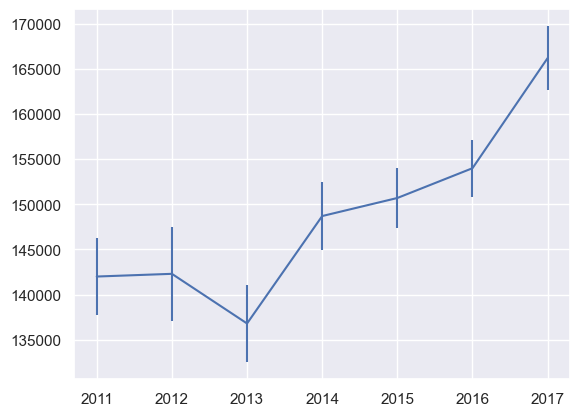

In [27]:
# Calculate and inspect Relative Margin of Error
philly["rmoe"] = 100 * philly['median_home_value_moe']/philly['median_home_value']
#print(philly)

# Create line plot with error bars of 90% MOE
plt.errorbar(x='year', y='median_home_value', yerr = 'median_home_value_moe', data = philly)
plt.show()

#### Significance of Differences in Estimates  

A line plot with error bars provides a visual indication of trends, but do the year-to-year differences in median home prices in Philadelphia represent statistically significant changes? To assess this, evaluate the differences in median home prices for each consecutive year from 2011 to 2017.  

The two-sample Z-statistic is calculated using the following formula:  

$$Z=\frac{(x_1-x_2)}{\sqrt{SE^2_{x_1}+SE^2_{x_2}}}$$  

In [30]:
from scipy.stats import norm
# Set the critical Z score for 90% confidence, prepare message
confidence_level = 0.90  # 90% confidence
alpha = (1 - confidence_level) / 2  # Divide by 2 for two tails
Z_CRIT = norm.ppf(1 - alpha)  # Inverse CDF for the upper critical value

#Z_CRIT = 1.645
msg = "Philadelphia median home values in {} were {}significantly different from {}."

for year in range(2012, 2018):
    # Assign current and prior year's median home value to variables
    x1 = int(philly[philly["year"] == year]["median_home_value"])
    x2 = int(philly[philly["year"] == year-1]["median_home_value"])
    
    # Calculate standard error as 90% MOE / critical Z score
    se_x1 = float(philly[philly["year"] == year]["median_home_value_moe"]/Z_CRIT)
    se_x2 = float(philly[philly["year"] == year-1]["median_home_value_moe"]/Z_CRIT)
    
    # Calculate two-sample z-statistic, output message if greater than critical Z score
    z = (x1 - x2) / sqrt(se_x1**2 + se_x2**2)
    print(msg.format(year, '' if abs(z) > Z_CRIT else 'not ', year - 1))

Philadelphia median home values in 2012 were not significantly different from 2011.
Philadelphia median home values in 2013 were not significantly different from 2012.
Philadelphia median home values in 2014 were significantly different from 2013.
Philadelphia median home values in 2015 were not significantly different from 2014.
Philadelphia median home values in 2016 were not significantly different from 2015.
Philadelphia median home values in 2017 were significantly different from 2016.


C:\Users\josue\AppData\Local\Temp\ipykernel_6420\2358619696.py:12: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x1 = int(philly[philly["year"] == year]["median_home_value"])
C:\Users\josue\AppData\Local\Temp\ipykernel_6420\2358619696.py:13: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  x2 = int(philly[philly["year"] == year-1]["median_home_value"])
C:\Users\josue\AppData\Local\Temp\ipykernel_6420\2358619696.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  se_x1 = float(philly[philly["year"] == year]["median_home_value_moe"]/Z_CRIT)
C:\Users\josue\AppData\Local\Temp\ipykernel_6420\2358619696.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in t

#### Significance of Difference of Proportions

Bike commuting is still uncommon, but Washington, DC, has a decent share. It has increased by over 1 percentage point in the last few years, but is this a statistically significant increase? calculate the standard error of a proportion, then a two-sample Z-statistic of the proportions.

The formula for the standard error (SE) of a proportion is:

 $$SE_P=\frac{1}{N}\sqrt{SE^2_{n}-P^2SE^2_{N}}$$

API The `dc` variable containing the Total Commuters and moe, bicycle commuting and moe

In [55]:
from scipy.stats import norm

# Define API base URL and parameters
HOST = "https://api.census.gov/data"  # Base URL for the U.S. Census API
dataset = "acs/acs1"  # Specify the dataset (American Community Survey 1-year estimates)
predicates = {}
predicates["get"] = ",".join(["NAME", "B08301_001E", "B08301_001M", "B08301_018E", "B08301_018M"])  # Request variables: Total Commuters and moe, bicycle commuting and moe
predicates['for'] = "state:11"  # FIPS code for Washington, D.C.

# Initialize an empty list to store yearly data
dfs = []
col_names = ["name",
             'total_est', 
             'total_moe', 
             'bike_est', 
             'bike_moe',
             "state"]  # Define DataFrame column names

# Loop through years 2011 to 2017
for year in range(2011, 2018):
    base_url = "/".join([HOST, str(year), dataset])  # Construct the API request URL for the given year
    r = requests.get(base_url, params=predicates)  # Send a GET request to the Census API with the specified parameters
    df = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Convert API response to a DataFrame, excluding header row
    df["year"] = year  # Add a column to indicate the year of the data
    dfs.append(df)  # Append the yearly DataFrame to the list

# Combine all yearly DataFrames into a single DataFrame
dc = pd.concat(dfs, ignore_index=True)  # Merge all yearly DataFrames and reset index
dc[['total_est', 'total_moe', 'bike_est',  'bike_moe']] = dc[['total_est', 'total_moe', 'bike_est',  'bike_moe']].astype(int)  # Convert bicycle commute data to integers

**`Z_CRIT`** cant be used the same as before (1.645)

In [102]:
# Calculate share of bike commuting
dc["bike_share"] = dc['bike_est']/dc['total_est']

# Calculate standard errors of the estimate from MOEs
dc["se_bike"] = dc['bike_moe']/Z_CRIT
dc["se_total"] = dc['total_moe']/Z_CRIT
dc["se_p"] = sqrt(dc["se_bike"]**2 - dc["bike_share"]**2 * dc["se_total"]**2)**0.5 / dc["total_est"]

# Calculate the two sample statistic between 2011 and 2017
numerator = dc.loc[dc['year'] == 2017, 'bike_share'].iloc[0]\
            - dc.loc[dc['year'] == 2011, 'bike_share'].iloc[0]
denominator = np.sqrt(dc.loc[dc['year'] == 2017, 'se_p'].iloc[0]**2\
                      + dc.loc[dc['year'] == 2011, 'se_p'].iloc[0]**2)
Z =  numerator/denominator

print(Z_CRIT < Z)

True


### Basic Mapping with Geopandas

#### Choropleth Map of Internet Access

Load a geospatial data file and create a basic choropleth map. The dataset comes from **ACS Table B28011** - *"Internet Subscriptions in Households"* and contains columns representing `total` households, those `with internet` access, and those `without internet` access, along with various types of internet connectivity.

Choropleth maps are most effective when displaying rates or proportions rather than raw counts. After loading the dataset, calculate the percentage of households without internet access by using the `no_internet` and `total` household columns.


In [108]:
# Define API base URL and parameters
HOST = "https://api.census.gov/data"  # Base URL for the U.S. Census API
dataset = "acs/acs1"  # Specify the dataset (American Community Survey 1-year estimates)
predicates = {}
predicates["get"] = ",".join(["NAME", "B28011_001E", "B28011_002E", "B28011_008E", "GEO_ID"])  # Request variables: Total Commuters and moe, bicycle commuting and moe
predicates['for'] = "state:*"  # FIPS code for Washington, D.C.

# Initialize an empty list to store yearly data
dfs = []
col_names = ["name",
             'total',
             'internet', 
             'no_internet', 
             'geometry', 
             "state"]  # Define DataFrame column names

# Loop through years 2011 to 2017
#for year in range(2011, 2018):
year=2017
base_url = "/".join([HOST, str(year), dataset])  # Construct the API request URL for the given year
r = requests.get(base_url, params=predicates)  # Send a GET request to the Census API with the specified parameters
df = pd.DataFrame(columns=col_names, data=r.json()[1:])  # Convert API response to a DataFrame, excluding header row
#df["year"] = year  # Add a column to indicate the year of the data
#dfs.append(df)  # Append the yearly DataFrame to the list

# Combine all yearly DataFrames into a single DataFrame
#dc = pd.concat(dfs, ignore_index=True)  # Merge all yearly DataFrames and reset index
df[[ 'total','internet', 'no_internet']] = df[[ 'total','internet', 'no_internet']].astype(int)  # Convert bicycle commute data to integers
df['geometry']=df['geometry'].astype('')

TypeError: data type '' not understood

Index(['state', 'postal', 'name', 'total', 'internet', 'dial_up', 'broadband',
       'satellite', 'other_service', 'internet_without_subscription',
       'no_internet', 'label_x', 'label_y', 'geometry'],
      dtype='object')


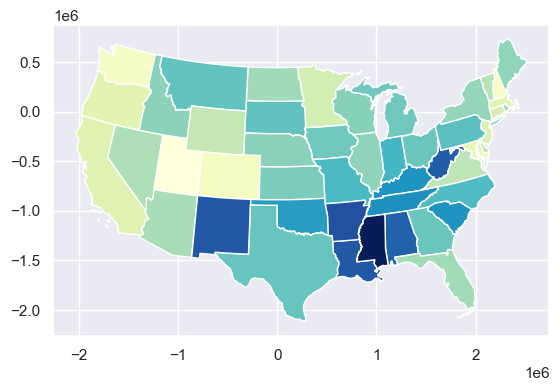

In [104]:
# import geopandas as gpd

# Load geospatial data
geo_state = gpd.read_file('states_internet.gpkg')

# View GeoDataFrame columns
print(geo_state.columns)

# Calculate percent of households with no internet
geo_state["pct_no_internet"] = 100 * geo_state['no_internet']/geo_state['total']

# Create choropleth map using YlGnBu colormap
geo_state.plot(column='pct_no_internet', cmap = 'YlGnBu')
plt.show()

In [106]:
geo_state.head()

,state,postal,name,total,internet,dial_up,broadband,satellite,other_service,internet_without_subscription,no_internet,label_x,label_y,geometry,pct_no_internet
0,06,CA,California,12888128,10708603,68137,9292907,783387,153121,375887,1803638,-1.708049e+06,-667730.621773,"MULTIPOLYGON (((-1716661.573 -1091585.267, -17...",13.994569
1,08,CO,Colorado,2082531,1760603,14444,1497662,147847,26520,68598,253330,-4.795022e+05,-650958.512053,"MULTIPOLYGON (((-787764.871 -679501.9, -787764...",12.164525
2,11,DC,District of Columbia,277985,216694,1037,195033,8542,3006,12719,48572,1.960213e+06,-403256.083210,"MULTIPOLYGON (((1950824.826 -402441.066, 19555...",17.472885
3,16,ID,Idaho,609124,476141,6054,365151,62011,9683,26236,106747,-1.153546e+06,32306.322359,"MULTIPOLYGON (((-1357254.591 77405.177, -13542...",17.524675
4,17,IL,Illinois,4818452,3806191,29112,3221458,271254,59063,174194,838067,9.171852e+05,-491248.597877,"MULTIPOLYGON (((720437.124 -496471.759, 720690...",17.392868


In [109]:
df.head()

,name,total,internet,no_internet,geometry,state
0,Mississippi,1091980,804401,252253,0400000US28,28
1,Missouri,2385135,1946500,359581,0400000US29,29
2,Montana,423091,346793,64140,0400000US30,30
3,Nebraska,754490,640404,97146,0400000US31,31
4,Nevada,1094613,915335,141949,0400000US32,32
